# Generative Adversarial Networks (GANs)

In this notebook, I will create **generative models** using neural networks. Specifically, we will  build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, there are two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

Here, We will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

## Dataset

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Ins

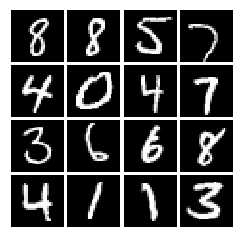

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x,alpha * x)


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [4]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform(shape=(batch_size,dim), minval = -1, maxval = 1)


## Discriminator
Our first step is to build a discriminator.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [5]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.layers.dense(x,256,activation=leaky_relu)
        x = tf.layers.dense(x,256,activation=leaky_relu)
        logits = tf.layers.dense(x,1,activation=None)
        return logits

## Generator
Now to build a generator.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        z = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        z = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        img = tf.layers.dense(z, 784, activation = tf.nn.tanh)
        return img

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.


In [7]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    part1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real), logits = logits_real))
    part2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake), logits = (logits_fake)))
    D_loss = part1 + part2
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake), logits = logits_fake ))
    return D_loss, G_loss

# Optimizing our loss
`AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    return D_solver, G_solver

## Putting it all together

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars) 
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN! 

In [10]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

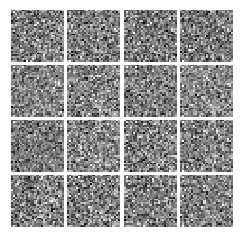


Iter: 0, D: 1.399, G:0.7483
Iter: 50, D: 0.2868, G:1.571
Iter: 100, D: 1.557, G:2.24
Iter: 150, D: 1.167, G:1.318
Iter: 200, D: 0.733, G:1.727


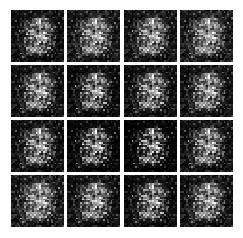


Iter: 250, D: 1.318, G:1.171
Iter: 300, D: 1.096, G:1.736
Iter: 350, D: 2.112, G:0.9552
Iter: 400, D: 1.615, G:2.368
Iter: 450, D: 0.8675, G:1.7


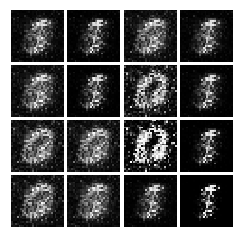


Iter: 500, D: 1.265, G:1.194
Iter: 550, D: 1.543, G:1.947
Iter: 600, D: 1.251, G:0.8861
Iter: 650, D: 1.698, G:2.911
Iter: 700, D: 1.079, G:1.664


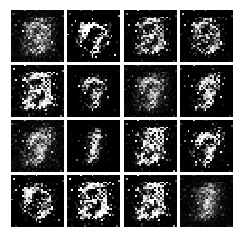


Iter: 750, D: 1.315, G:1.066
Iter: 800, D: 1.091, G:2.387
Iter: 850, D: 1.152, G:1.172
Iter: 900, D: 1.265, G:1.5
Iter: 950, D: 1.195, G:1.677


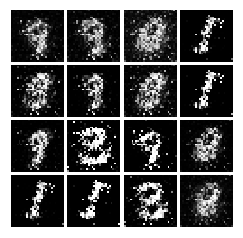


Iter: 1000, D: 1.253, G:1.429
Iter: 1050, D: 1.111, G:1.375
Iter: 1100, D: 1.099, G:1.698
Iter: 1150, D: 1.405, G:1.26
Iter: 1200, D: 1.382, G:1.199


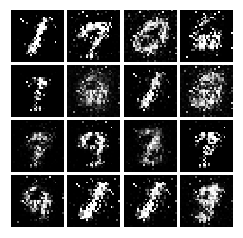


Iter: 1250, D: 1.268, G:0.9116
Iter: 1300, D: 1.205, G:1.124
Iter: 1350, D: 1.292, G:0.9693
Iter: 1400, D: 1.279, G:1.036
Iter: 1450, D: 1.307, G:1.176


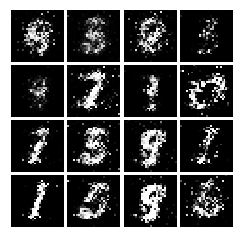


Iter: 1500, D: 1.162, G:1.296
Iter: 1550, D: 1.288, G:0.9377
Iter: 1600, D: 1.667, G:0.7255
Iter: 1650, D: 1.307, G:0.8165
Iter: 1700, D: 1.314, G:0.8727


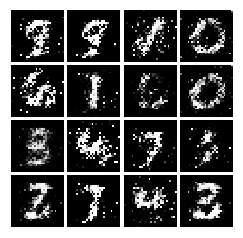


Iter: 1750, D: 1.284, G:0.8609
Iter: 1800, D: 1.409, G:0.9252
Iter: 1850, D: 1.295, G:0.8734
Iter: 1900, D: 1.414, G:0.7582
Iter: 1950, D: 1.375, G:0.8746


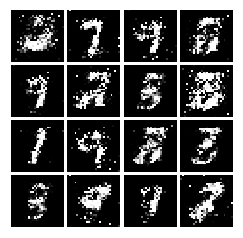


Iter: 2000, D: 1.26, G:0.8728
Iter: 2050, D: 1.298, G:0.848
Iter: 2100, D: 1.272, G:0.8037
Iter: 2150, D: 1.305, G:0.9449
Iter: 2200, D: 1.203, G:0.9769


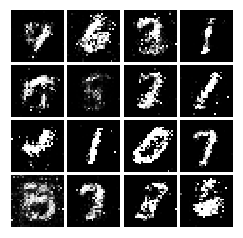


Iter: 2250, D: 1.356, G:0.7963
Iter: 2300, D: 1.331, G:0.8714
Iter: 2350, D: 1.356, G:0.9024
Iter: 2400, D: 1.314, G:0.8408
Iter: 2450, D: 1.329, G:0.78


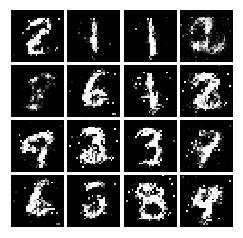


Iter: 2500, D: 1.293, G:0.6254
Iter: 2550, D: 1.274, G:0.9755
Iter: 2600, D: 1.327, G:0.6547
Iter: 2650, D: 1.301, G:0.8346
Iter: 2700, D: 1.292, G:0.8609


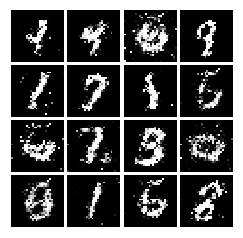


Iter: 2750, D: 1.288, G:0.8292
Iter: 2800, D: 1.272, G:0.9599
Iter: 2850, D: 1.417, G:0.7829
Iter: 2900, D: 1.3, G:0.8303
Iter: 2950, D: 1.353, G:0.8731


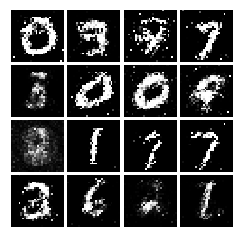


Iter: 3000, D: 1.325, G:0.9327
Iter: 3050, D: 1.34, G:0.8702
Iter: 3100, D: 1.329, G:0.8876
Iter: 3150, D: 1.396, G:0.7717
Iter: 3200, D: 1.273, G:0.9189


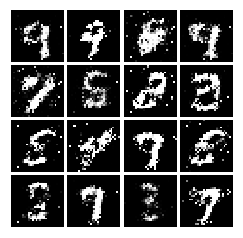


Iter: 3250, D: 1.312, G:0.8321
Iter: 3300, D: 1.324, G:0.9142
Iter: 3350, D: 1.331, G:0.6487
Iter: 3400, D: 1.423, G:0.8372
Iter: 3450, D: 1.333, G:0.8445


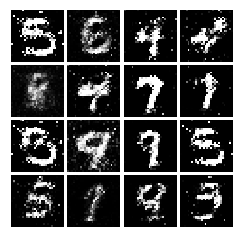


Iter: 3500, D: 1.291, G:0.8484
Iter: 3550, D: 1.282, G:0.8142
Iter: 3600, D: 1.354, G:0.8624
Iter: 3650, D: 1.341, G:0.8808
Iter: 3700, D: 1.385, G:0.8935


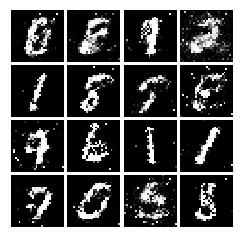


Iter: 3750, D: 1.274, G:0.8412
Iter: 3800, D: 1.334, G:0.9136
Iter: 3850, D: 1.33, G:0.8101
Iter: 3900, D: 1.37, G:0.8409
Iter: 3950, D: 1.309, G:0.7903


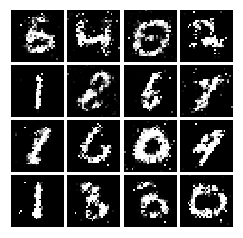


Iter: 4000, D: 1.323, G:0.7145
Iter: 4050, D: 1.356, G:0.795
Iter: 4100, D: 1.308, G:0.7548
Iter: 4150, D: 1.299, G:0.8689
Iter: 4200, D: 1.251, G:0.8456


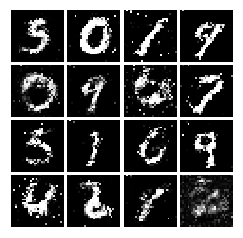


Iter: 4250, D: 1.336, G:0.937
Final images


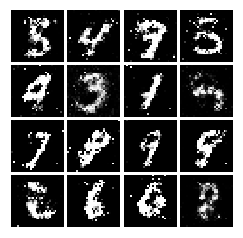

In [93]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [11]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    part1 = 0.5 * tf.reduce_mean(tf.square(score_real - 1))
    part2 = 0.5 * tf.reduce_mean(tf.square(score_fake))
    D_loss = part1 + part2
    G_loss = 0.5 * tf.reduce_mean(tf.square(score_fake - 1))
    return D_loss, G_loss

In [12]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

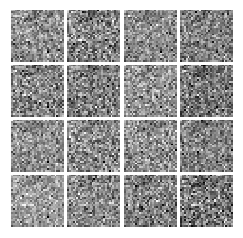


Iter: 0, D: 2.429, G:0.4594
Iter: 50, D: 0.03757, G:0.5256
Iter: 100, D: 0.02563, G:0.5515
Iter: 150, D: 0.007944, G:0.5168
Iter: 200, D: 0.5221, G:0.8073


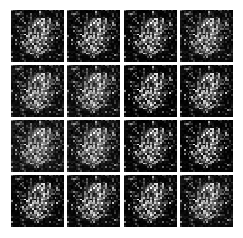


Iter: 250, D: 0.2358, G:0.4936
Iter: 300, D: 0.3675, G:0.7282
Iter: 350, D: 0.1363, G:0.2359
Iter: 400, D: 0.1349, G:0.4215
Iter: 450, D: 0.3937, G:0.02547


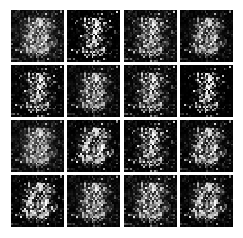


Iter: 500, D: 0.227, G:0.8431
Iter: 550, D: 0.1143, G:0.4333
Iter: 600, D: 0.1133, G:0.4851
Iter: 650, D: 0.1363, G:0.2911
Iter: 700, D: 0.1296, G:0.565


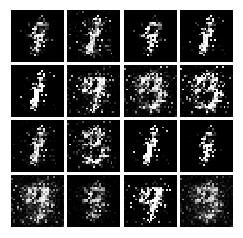


Iter: 750, D: 0.16, G:0.3449
Iter: 800, D: 0.1386, G:0.3819
Iter: 850, D: 0.1473, G:0.3596
Iter: 900, D: 0.1324, G:0.5286
Iter: 950, D: 0.1203, G:1.381


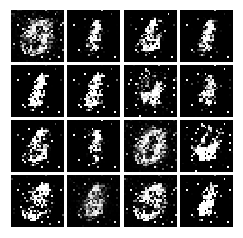


Iter: 1000, D: 0.2089, G:0.4143
Iter: 1050, D: 0.1322, G:0.3439
Iter: 1100, D: 0.1801, G:0.7738
Iter: 1150, D: 0.1391, G:0.3291
Iter: 1200, D: 0.1771, G:0.2377


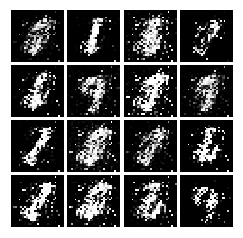


Iter: 1250, D: 0.1311, G:0.3317
Iter: 1300, D: 0.1742, G:0.1448
Iter: 1350, D: 0.153, G:0.1974
Iter: 1400, D: 0.159, G:0.2414
Iter: 1450, D: 0.1349, G:0.2701


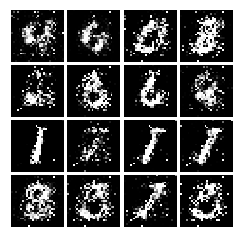


Iter: 1500, D: 0.1707, G:0.2653
Iter: 1550, D: 0.1993, G:0.212
Iter: 1600, D: 0.1761, G:0.2082
Iter: 1650, D: 0.1987, G:0.2104
Iter: 1700, D: 0.2313, G:0.2142


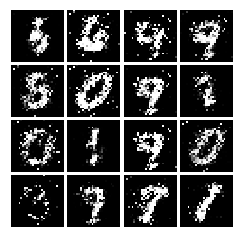


Iter: 1750, D: 0.2241, G:0.2865
Iter: 1800, D: 0.1995, G:0.1865
Iter: 1850, D: 0.2336, G:0.1738
Iter: 1900, D: 0.2114, G:0.2246
Iter: 1950, D: 0.2231, G:0.1865


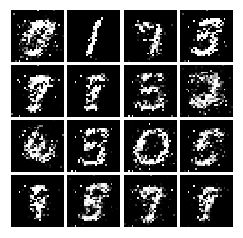


Iter: 2000, D: 0.2108, G:0.2068
Iter: 2050, D: 0.2084, G:0.2109
Iter: 2100, D: 0.2194, G:0.1742
Iter: 2150, D: 0.2128, G:0.2001
Iter: 2200, D: 0.2276, G:0.1563


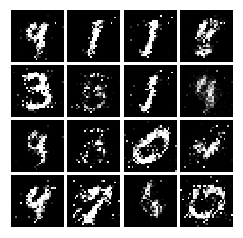


Iter: 2250, D: 0.2132, G:0.1918
Iter: 2300, D: 0.213, G:0.2144
Iter: 2350, D: 0.2076, G:0.2015
Iter: 2400, D: 0.2286, G:0.1756
Iter: 2450, D: 0.2133, G:0.1786


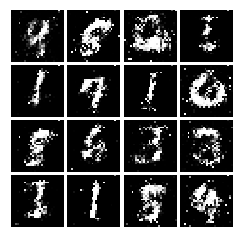


Iter: 2500, D: 0.2305, G:0.1748
Iter: 2550, D: 0.2099, G:0.221
Iter: 2600, D: 0.2309, G:0.1788
Iter: 2650, D: 0.2483, G:0.2138
Iter: 2700, D: 0.2062, G:0.181


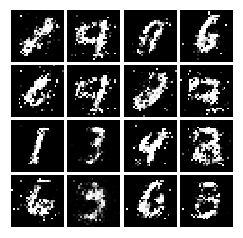


Iter: 2750, D: 0.214, G:0.1772
Iter: 2800, D: 0.2314, G:0.1597
Iter: 2850, D: 0.2421, G:0.2328
Iter: 2900, D: 0.2328, G:0.195
Iter: 2950, D: 0.2238, G:0.2164


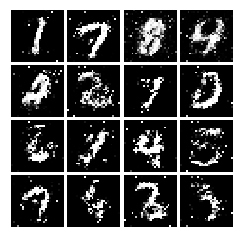


Iter: 3000, D: 0.2189, G:0.1809
Iter: 3050, D: 0.2285, G:0.1592
Iter: 3100, D: 0.2051, G:0.1849
Iter: 3150, D: 0.2543, G:0.1804
Iter: 3200, D: 0.2367, G:0.1629


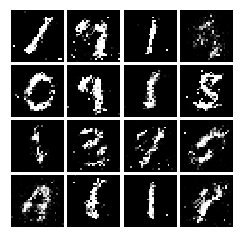


Iter: 3250, D: 0.2045, G:0.1628
Iter: 3300, D: 0.2148, G:0.1678
Iter: 3350, D: 0.244, G:0.1917
Iter: 3400, D: 0.2128, G:0.195
Iter: 3450, D: 0.2243, G:0.1743


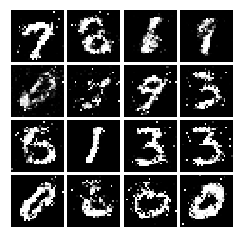


Iter: 3500, D: 0.2127, G:0.1605
Iter: 3550, D: 0.2336, G:0.1884
Iter: 3600, D: 0.2232, G:0.1758
Iter: 3650, D: 0.215, G:0.1898
Iter: 3700, D: 0.2445, G:0.1872


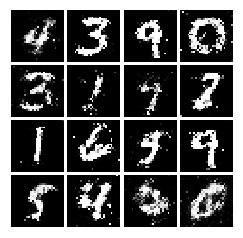


Iter: 3750, D: 0.2286, G:0.1698
Iter: 3800, D: 0.2062, G:0.1809
Iter: 3850, D: 0.2225, G:0.1472
Iter: 3900, D: 0.2123, G:0.1817
Iter: 3950, D: 0.2278, G:0.1827


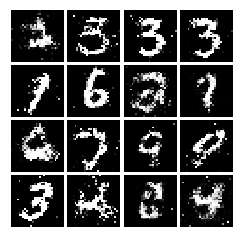


Iter: 4000, D: 0.2239, G:0.162
Iter: 4050, D: 0.2246, G:0.1541
Iter: 4100, D: 0.2103, G:0.1764
Iter: 4150, D: 0.2209, G:0.1862
Iter: 4200, D: 0.2251, G:0.1718


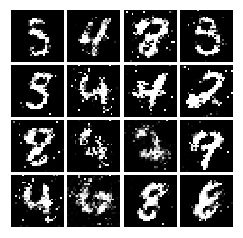


Iter: 4250, D: 0.2189, G:0.1935
Final images


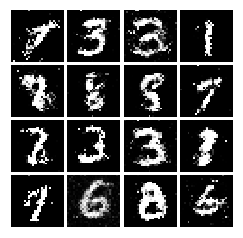

In [53]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [56]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
#         print(x.get_shape().as_list())
        x = tf.reshape(x,shape = [-1,28,28,1])
        x = tf.layers.conv2d(x, 32, 5, padding='valid', activation = leaky_relu)
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x, 64, 5, padding='valid', activation = leaky_relu)
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, shape= [-1,4 * 4 * 64])
        x = tf.layers.dense(x,4 * 4 * 64, activation= leaky_relu)
        logits = tf.layers.dense(x, 1)        
        return logits

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [57]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        x = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        x = tf.layers.batch_normalization(x)
        x = tf.layers.dense(x, 7 * 7 * 128, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x)
        x = tf.reshape(x , [-1, 7, 7, 128])
        x = tf.layers.conv2d_transpose(x,64,4,2,activation=tf.nn.relu,padding='same')
        x = tf.layers.batch_normalization(x)
        img = tf.layers.conv2d_transpose(x,1,4,2,activation=tf.nn.tanh,padding='same')
        return img

We have to recreate our network since we've changed our functions.

In [58]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)
# G_sample = G_sample[:,:28,:28,:]

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator') # remove these and check
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

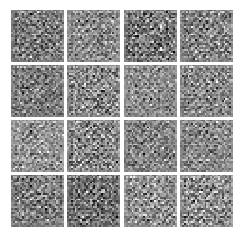


Iter: 0, D: 0.5095, G:0.418
Iter: 50, D: 0.03707, G:0.3263
Iter: 100, D: 0.03997, G:0.5389
Iter: 150, D: 0.008489, G:0.6253
Iter: 200, D: 0.1199, G:0.3441


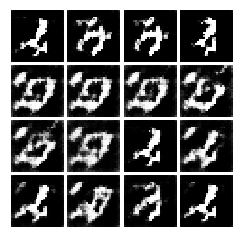


Iter: 250, D: 0.0494, G:0.43
Iter: 300, D: 0.09152, G:0.2495
Iter: 350, D: 0.08717, G:0.4549
Iter: 400, D: 0.1537, G:0.22
Iter: 450, D: 0.1081, G:0.434


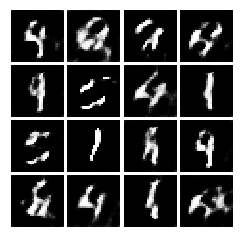


Iter: 500, D: 0.1068, G:0.3073
Iter: 550, D: 0.1184, G:0.3294
Iter: 600, D: 0.1437, G:0.2741
Iter: 650, D: 0.1315, G:0.3869
Iter: 700, D: 0.1105, G:0.2857


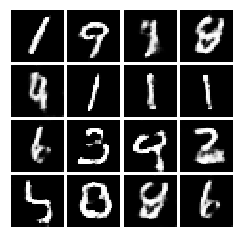


Iter: 750, D: 0.1384, G:0.3143
Iter: 800, D: 0.1294, G:0.3303
Iter: 850, D: 0.1692, G:0.3255
Iter: 900, D: 0.1261, G:0.3425
Iter: 950, D: 0.1718, G:0.2883


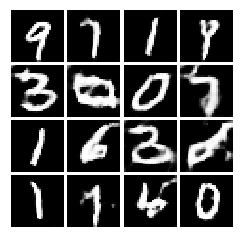


Iter: 1000, D: 0.1732, G:0.2108
Iter: 1050, D: 0.1465, G:0.2294
Iter: 1100, D: 0.199, G:0.2273
Iter: 1150, D: 0.1625, G:0.2354
Iter: 1200, D: 0.1697, G:0.281


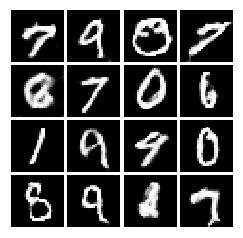


Iter: 1250, D: 0.1902, G:0.2632
Iter: 1300, D: 0.1675, G:0.2331
Iter: 1350, D: 0.1771, G:0.2928
Iter: 1400, D: 0.1715, G:0.2017
Iter: 1450, D: 0.1538, G:0.2576


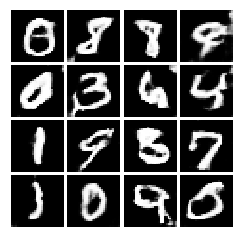


Iter: 1500, D: 0.1731, G:0.2191
Iter: 1550, D: 0.1647, G:0.2067
Iter: 1600, D: 0.1974, G:0.2447
Iter: 1650, D: 0.1758, G:0.2379
Iter: 1700, D: 0.1503, G:0.2668


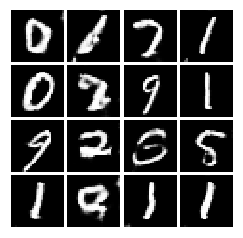


Iter: 1750, D: 0.1857, G:0.1978
Iter: 1800, D: 0.1808, G:0.1825
Iter: 1850, D: 0.1544, G:0.2732
Iter: 1900, D: 0.1656, G:0.2411
Iter: 1950, D: 0.1763, G:0.1911


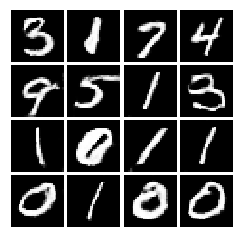


Iter: 2000, D: 0.1742, G:0.1552
Iter: 2050, D: 0.1807, G:0.2357
Iter: 2100, D: 0.183, G:0.1844
Iter: 2150, D: 0.164, G:0.1982
Iter: 2200, D: 0.1673, G:0.1665


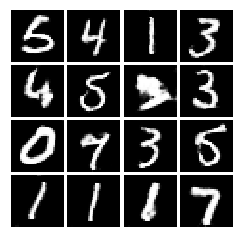


Iter: 2250, D: 0.2013, G:0.1284
Iter: 2300, D: 0.1418, G:0.2782
Iter: 2350, D: 0.1632, G:0.26
Iter: 2400, D: 0.1986, G:0.1586
Iter: 2450, D: 0.1673, G:0.2241


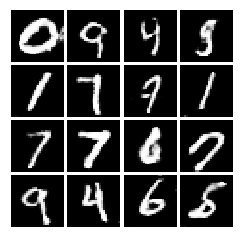


Iter: 2500, D: 0.1613, G:0.2177
Iter: 2550, D: 0.1514, G:0.2369
Iter: 2600, D: 0.1928, G:0.291
Iter: 2650, D: 0.1654, G:0.2315
Iter: 2700, D: 0.1503, G:0.2369


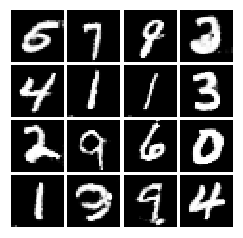


Iter: 2750, D: 0.1577, G:0.2353
Iter: 2800, D: 0.1666, G:0.2549
Iter: 2850, D: 0.1541, G:0.2938
Iter: 2900, D: 0.1699, G:0.3176
Iter: 2950, D: 0.1454, G:0.2449


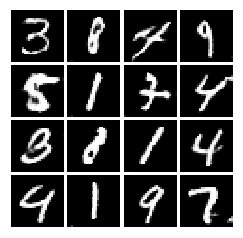


Iter: 3000, D: 0.1731, G:0.1804
Iter: 3050, D: 0.171, G:0.1736
Iter: 3100, D: 0.149, G:0.2551
Iter: 3150, D: 0.1913, G:0.1458
Iter: 3200, D: 0.1451, G:0.306


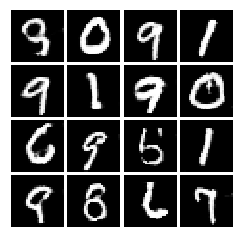


Iter: 3250, D: 0.1767, G:0.1489
Iter: 3300, D: 0.1619, G:0.262
Iter: 3350, D: 0.1964, G:0.3818
Iter: 3400, D: 0.1615, G:0.3693
Iter: 3450, D: 0.1308, G:0.2787


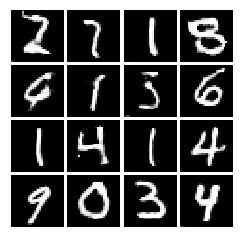


Iter: 3500, D: 0.1448, G:0.2368
Iter: 3550, D: 0.131, G:0.2258
Iter: 3600, D: 0.1634, G:0.3361
Iter: 3650, D: 0.1543, G:0.3161
Iter: 3700, D: 0.1579, G:0.1979


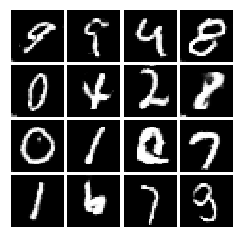


Iter: 3750, D: 0.131, G:0.2533
Iter: 3800, D: 0.146, G:0.2235
Iter: 3850, D: 0.1397, G:0.3062
Iter: 3900, D: 0.1259, G:0.3969
Iter: 3950, D: 0.1491, G:0.2913


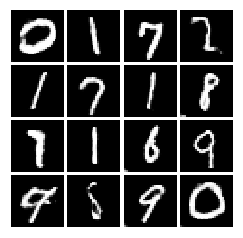


Iter: 4000, D: 0.1529, G:0.4094
Iter: 4050, D: 0.1379, G:0.2529
Iter: 4100, D: 0.1343, G:0.2355
Iter: 4150, D: 0.1428, G:0.2155
Iter: 4200, D: 0.1147, G:0.326


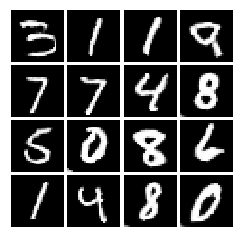


Iter: 4250, D: 0.1227, G:0.2508
Final images


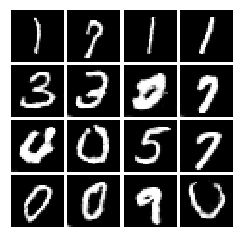

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# WGAN-GP 

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [59]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,64,4,2,padding='valid',activation=leaky_relu)
        x = tf.layers.conv2d(x,128,4,2,padding='valid',activation=leaky_relu)
        x = tf.layers.batch_normalization(x)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x,1024,activation=leaky_relu)
        logits = tf.layers.dense(x,1)
        return logits

In [60]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [61]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = -( tf.reduce_mean(logits_real) - tf.reduce_mean(logits_fake) )
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform(shape = [batch_size, 1],minval = 0,maxval = 1)
    x_hat = eps * x + (1 - eps) * tf.reshape(G_sample, [batch_size, -1])

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat),x_hat)

    grad_norm = tf.norm(grad_D_x_hat)
    grad_pen = lam * tf.square(grad_norm-1)
    
    D_loss += grad_pen



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

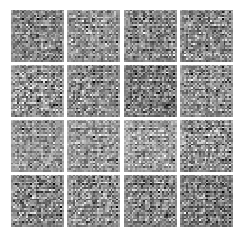


Iter: 0, D: -0.04637, G:-0.04803
Iter: 50, D: -0.9845, G:0.3006
Iter: 100, D: 1.033, G:0.3586
Iter: 150, D: -1.116, G:0.7248
Iter: 200, D: -0.6249, G:-1.392


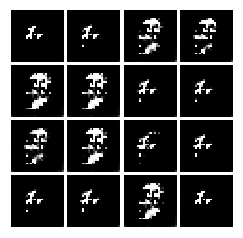


Iter: 250, D: -0.6039, G:0.3159
Iter: 300, D: -0.5157, G:0.6379
Iter: 350, D: -0.9054, G:0.1674
Iter: 400, D: -0.6618, G:-0.6737
Iter: 450, D: -0.8353, G:-0.7233


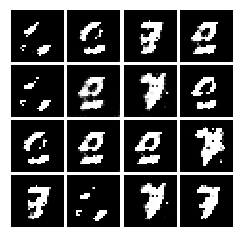


Iter: 500, D: -0.7849, G:-0.7775
Iter: 550, D: -0.764, G:-0.3529
Iter: 600, D: -0.2982, G:0.6136
Iter: 650, D: -0.3698, G:-0.3471
Iter: 700, D: -0.5282, G:-0.749


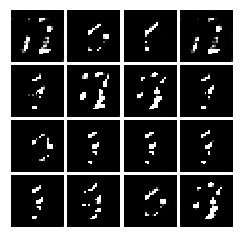


Iter: 750, D: 0.03869, G:0.0931
Iter: 800, D: -0.2024, G:1.295
Iter: 850, D: -0.2552, G:-0.1202
Iter: 900, D: -0.2147, G:1.115
Iter: 950, D: -0.3464, G:1.477


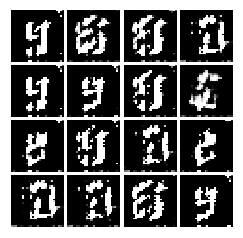


Iter: 1000, D: -0.09431, G:0.0416
Iter: 1050, D: -0.04624, G:-1.251
Iter: 1100, D: -0.3686, G:-0.4252
Iter: 1150, D: -0.1789, G:-0.7834
Iter: 1200, D: -0.1929, G:0.518


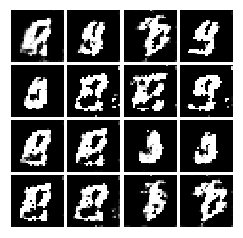


Iter: 1250, D: -0.04565, G:0.3776
Iter: 1300, D: -0.197, G:0.586
Iter: 1350, D: -0.02118, G:-0.1006
Iter: 1400, D: 0.2684, G:-1.022
Iter: 1450, D: -0.08162, G:-0.3822


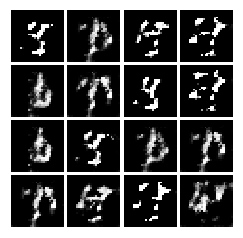


Iter: 1500, D: -0.2208, G:-1.021
Iter: 1550, D: -0.04255, G:-0.3706
Iter: 1600, D: -0.1235, G:-0.7809
Iter: 1650, D: -0.05568, G:-0.3854
Iter: 1700, D: -0.03628, G:-0.643


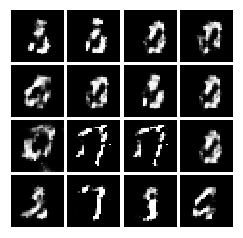


Iter: 1750, D: -0.1735, G:-0.7754
Iter: 1800, D: 0.04431, G:-0.7844
Iter: 1850, D: -0.07388, G:-0.5296
Iter: 1900, D: -0.1022, G:-0.5009
Iter: 1950, D: -0.1215, G:-2.159


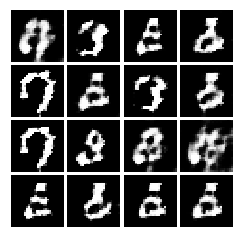


Iter: 2000, D: -0.1325, G:-0.8305
Iter: 2050, D: -0.1429, G:-0.3804
Iter: 2100, D: -0.1167, G:-0.693
Iter: 2150, D: -0.08248, G:-0.1608
Iter: 2200, D: -0.1244, G:-0.7382


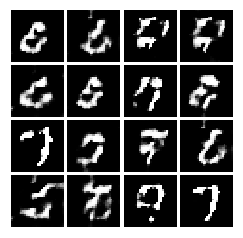


Iter: 2250, D: -0.02638, G:-0.4949
Iter: 2300, D: -0.1217, G:-0.412
Iter: 2350, D: -0.002246, G:-0.8533
Iter: 2400, D: -0.0522, G:-0.6577
Iter: 2450, D: -0.1232, G:-0.3118


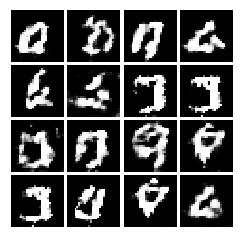


Iter: 2500, D: 0.1091, G:0.354
Iter: 2550, D: -0.02031, G:-0.1332
Final images


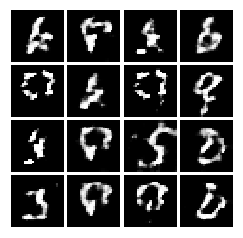

In [62]:
with get_session() as sess:
    # sess = get_session()
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=6)